# HVNM Tutorial 00: Data Intake and Quality Control

## Introduction

This notebook demonstrates **data loading and quality control workflows** for HVNM Bayesian inference across six rheological protocols: flow curve, creep, relaxation, startup, SAOS, and LAOS. Each dataset is loaded into a `ProtocolData` object with metadata, protocol-specific kwargs (e.g., `sigma_applied` for creep, `gamma_dot` for startup), and boolean masks for QC filtering. The workflow checks for NaN/Inf, non-positivity, monotonicity violations, and outliers. Early-time exclusion (creep), transient cycle dropping (LAOS), and log-time spacing validation (relaxation) ensure clean data for downstream NLSQ→NUTS pipelines.

> **Handbook:** See [HVNM Knowledge Extraction](../../docs/source/models/hvnm/hvnm_knowledge.rst) for multi-protocol fitting strategies and cross-protocol validation.

## Protocols and Data Sources

| Protocol | Dataset | Source |
|----------|---------|--------|
| Flow curve | Ethyl cellulose 7% solution | pyRheo demos |
| Creep | Polystyrene at 190 °C | pyRheo demos |
| Relaxation | Liquid foam | pyRheo demos |
| Startup | PNAS Digital Rheometer Twin | PNAS 2022 |
| SAOS | Epstein metal-organic network | Epstein et al. (JACS 2019) |
| LAOS | PNAS Digital Rheometer Twin | PNAS 2022 |

## Learning Objectives

- Load experimental data from CSV/Excel into `ProtocolData` schema
- Apply protocol-specific QC checks (positivity, monotonicity, outliers)
- Visualize and inspect raw data before modeling
- Prepare masked datasets for NLSQ/NUTS workflows

## Prerequisites
- Basic Python, NumPy, Matplotlib

## Estimated Runtime
- ~30 s (data loading + plotting only)

## 1. Setup

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax openpyxl
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed.")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Add parent to path so utils are importable
sys.path.insert(0, "../..")
from examples.utils.hvnm_tutorial_utils import (
    ProtocolData,
    load_ec_flow_curve,
    load_epstein_saos,
    load_foam_relaxation,
    load_pnas_laos,
    load_pnas_startup,
    load_ps_creep,
    plot_raw_data,
    save_figure,
    setup_style,
)

setup_style()
print("Utilities loaded.")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

Utilities loaded.


## 2. Load All Datasets

Each loader returns a `ProtocolData` object containing:
- `x`, `y`: primary data arrays
- `metadata`: material, source, units
- `mask`: boolean mask for valid points
- `protocol_kwargs`: extra args for model (e.g., `sigma_applied` for creep)

In [3]:
# Load all 6 protocol datasets
flow_data = load_ec_flow_curve("07-00")
creep_data = load_ps_creep(temperature=190, max_points=200)
relax_data = load_foam_relaxation(max_points=200)
startup_data = load_pnas_startup(gamma_dot=1.0, max_points=300)
saos_data = load_epstein_saos()
laos_data = load_pnas_laos(omega=1.0, strain_amplitude_index=5, max_points=500)

all_data = {
    "flow_curve": flow_data,
    "creep": creep_data,
    "relaxation": relax_data,
    "startup": startup_data,
    "oscillation": saos_data,
    "laos": laos_data,
}

for name, d in all_data.items():
    print(f"\n{name.upper()}")
    print(d.summary())


FLOW_CURVE
Protocol: flow_curve
  Points: 43 / 43
  x range: [0.1, 1000]
  y range: [0.419, 869]
  material: Ethyl Cellulose 07.00 wt%
  source: pyRheo demos
  units_x: 1/s
  units_y: Pa

CREEP
Protocol: creep
  Points: 200 / 200
  x range: [0.2009, 3605]
  y range: [2.61e-05, 0.05367]
  material: Polystyrene at 190 C
  source: pyRheo demos
  units_x: s
  units_y: 1/Pa
  temperature_C: 190

RELAXATION
Protocol: relaxation
  Points: 200 / 200
  x range: [0.4023, 1399]
  y range: [4.545, 175.2]
  material: Liquid foam
  source: pyRheo demos
  units_x: s
  units_y: Pa

STARTUP
Protocol: startup
  Points: 300 / 300
  x range: [0.005331, 600]
  y range: [0.6885, 26.44]
  material: PNAS Digital Rheometer Twin sample
  source: PNAS 2022 Digital Rheometer Twin
  units_x: s
  units_y: Pa
  gamma_dot: 1.0

OSCILLATION
Protocol: oscillation
  Points: 19 / 19
  x range: [0.1008, 99.42]
  y range: [29, 3674]
  material: Metal-organic coordination network (Epstein et al.)
  source: Epstein et al. (

## 3. Quality Control Checks

For each dataset we check:
1. **NaN/Inf**: Detect missing or infinite values
2. **Positivity**: Physical quantities must be positive
3. **Monotonicity**: x must be strictly monotonic (sorted)
4. **Outliers**: Flag points > 5 sigma from local trend
5. **Range**: Verify physically reasonable ranges

In [4]:
def qc_check(data: ProtocolData) -> dict:
    """Run quality control checks on a ProtocolData."""
    x, y = data.x, data.y
    issues = []
    
    # NaN / Inf
    n_nan_x = np.sum(np.isnan(x))
    n_nan_y = np.sum(np.isnan(y))
    n_inf_x = np.sum(np.isinf(x))
    n_inf_y = np.sum(np.isinf(y))
    if n_nan_x + n_nan_y > 0:
        issues.append(f"NaN detected: x={n_nan_x}, y={n_nan_y}")
    if n_inf_x + n_inf_y > 0:
        issues.append(f"Inf detected: x={n_inf_x}, y={n_inf_y}")
    
    # Positivity (for most protocols)
    if data.protocol not in ("laos",):
        n_neg_x = np.sum(x <= 0)
        n_neg_y = np.sum(y <= 0)
        if n_neg_x > 0:
            issues.append(f"Non-positive x values: {n_neg_x}")
        if n_neg_y > 0 and data.protocol != "startup":
            issues.append(f"Non-positive y values: {n_neg_y}")
    
    # Monotonicity of x (for flow, SAOS, creep, relaxation)
    if data.protocol in ("flow_curve", "oscillation", "creep", "relaxation"):
        diffs = np.diff(x)
        if not np.all(diffs > 0):
            n_nonmono = np.sum(diffs <= 0)
            issues.append(f"Non-monotonic x: {n_nonmono} reversals")
    
    # Dynamic range
    x_range = x.max() / max(x.min(), 1e-30)
    y_range = y[y > 0].max() / max(y[y > 0].min(), 1e-30) if np.any(y > 0) else 0
    
    # Simple outlier detection: > 5 sigma from rolling median
    n_outliers = 0
    if len(y) > 10 and data.protocol not in ("laos", "startup"):
        log_y = np.log10(np.maximum(np.abs(y), 1e-30))
        window = max(5, len(y) // 10)
        rolling_med = np.convolve(log_y, np.ones(window) / window, mode='same')
        residuals = np.abs(log_y - rolling_med)
        sigma = np.std(residuals)
        n_outliers = int(np.sum(residuals > 5 * sigma)) if sigma > 0 else 0
        if n_outliers > 0:
            issues.append(f"Potential outliers: {n_outliers} points")
    
    status = "PASS" if not issues else "REVIEW"
    return {
        "protocol": data.protocol,
        "n_points": len(x),
        "x_range": x_range,
        "y_range": y_range,
        "n_outliers": n_outliers,
        "issues": issues,
        "status": status,
    }


print("Quality Control Report")
print("=" * 70)
for name, d in all_data.items():
    qc = qc_check(d)
    print(f"\n{name.upper()} [{qc['status']}]")
    print(f"  Points: {qc['n_points']}")
    print(f"  x dynamic range: {qc['x_range']:.1f}x")
    print(f"  y dynamic range: {qc['y_range']:.1f}x")
    if qc['issues']:
        for issue in qc['issues']:
            print(f"  ! {issue}")
    else:
        print("  All checks passed.")

Quality Control Report

FLOW_CURVE [REVIEW]
  Points: 43
  x dynamic range: 10000.0x
  y dynamic range: 2074.0x
  ! Potential outliers: 1 points

CREEP [REVIEW]
  Points: 200
  x dynamic range: 17944.3x
  y dynamic range: 2056.4x
  ! Potential outliers: 3 points

RELAXATION [REVIEW]
  Points: 200
  x dynamic range: 3478.6x
  y dynamic range: 38.5x
  ! Potential outliers: 4 points

STARTUP [PASS]
  Points: 300
  x dynamic range: 112554.9x
  y dynamic range: 38.4x
  All checks passed.

OSCILLATION [PASS]
  Points: 19
  x dynamic range: 986.5x
  y dynamic range: 126.7x
  All checks passed.

LAOS [PASS]
  Points: 500
  x dynamic range: 12528.0x
  y dynamic range: 38.6x
  All checks passed.


## 4. Visualize All Datasets

Overview of all 6 protocols on a single figure.

Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_00_data_overview.png


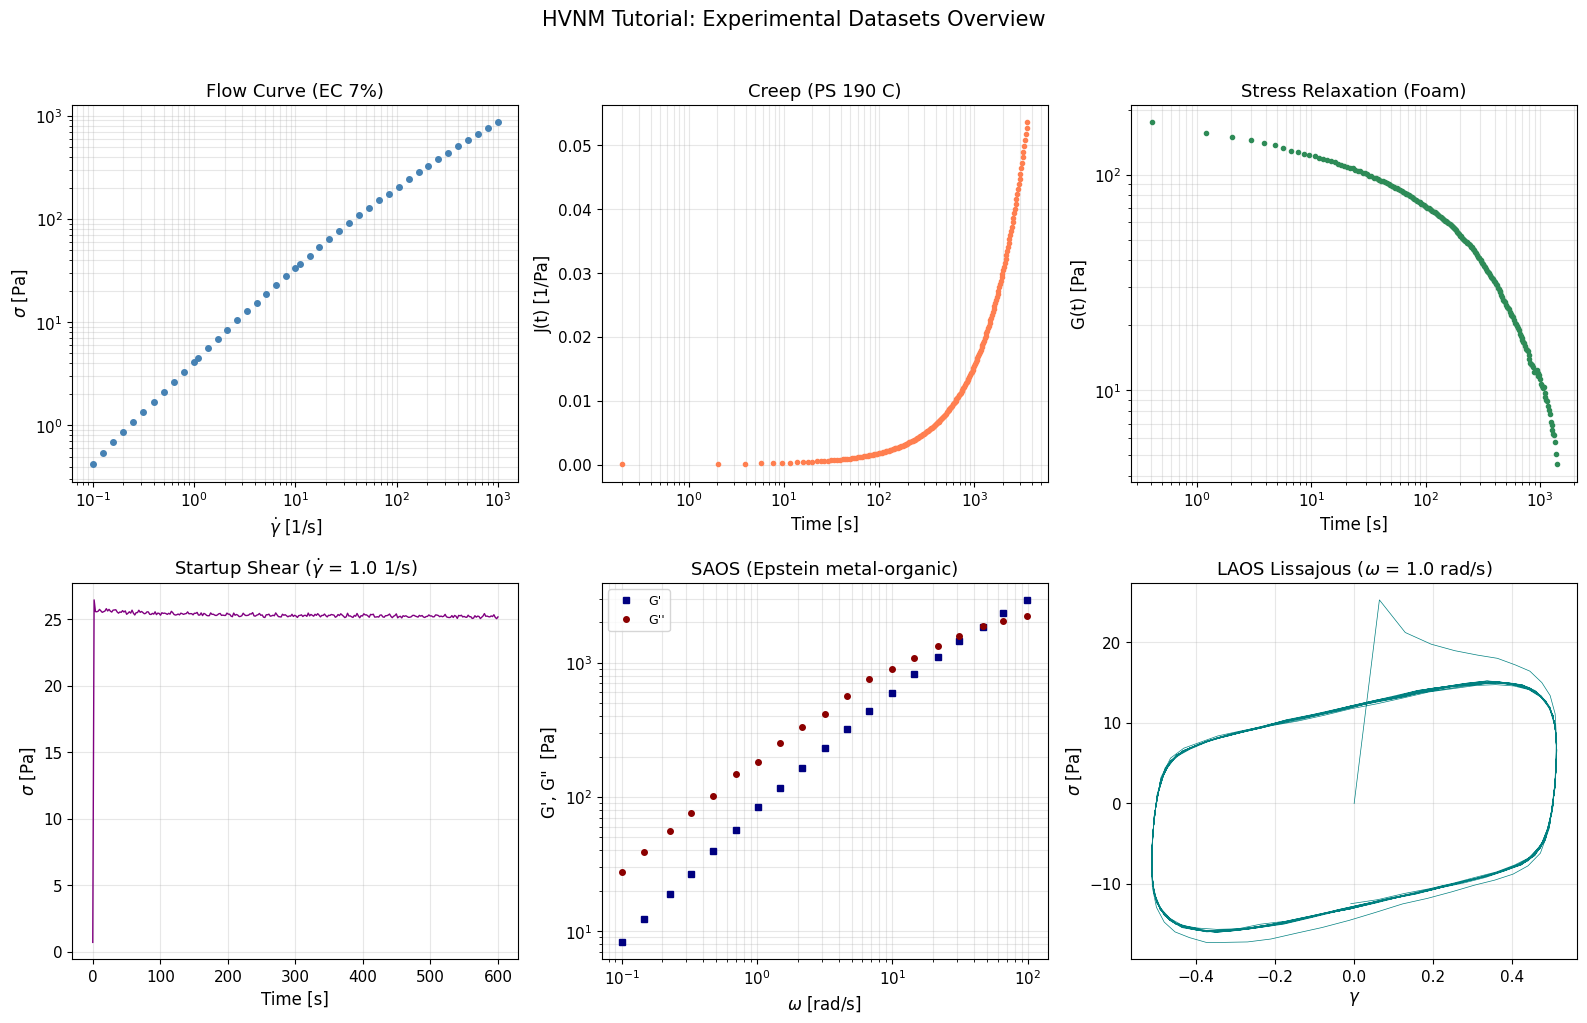

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Flow curve
ax = axes[0, 0]
ax.loglog(flow_data.x, flow_data.y, 'o', ms=4, color='steelblue')
ax.set_xlabel(flow_data.x_label)
ax.set_ylabel(flow_data.y_label)
ax.set_title('Flow Curve (EC 7%)')
ax.grid(True, alpha=0.3, which='both')

# Creep
ax = axes[0, 1]
ax.semilogx(creep_data.x, creep_data.y, 'o', ms=3, color='coral')
ax.set_xlabel(creep_data.x_label)
ax.set_ylabel(creep_data.y_label)
ax.set_title('Creep (PS 190 C)')
ax.grid(True, alpha=0.3, which='both')

# Relaxation
ax = axes[0, 2]
ax.loglog(relax_data.x, relax_data.y, 'o', ms=3, color='seagreen')
ax.set_xlabel(relax_data.x_label)
ax.set_ylabel(relax_data.y_label)
ax.set_title('Stress Relaxation (Foam)')
ax.grid(True, alpha=0.3, which='both')

# Startup
ax = axes[1, 0]
ax.plot(startup_data.x, startup_data.y, '-', lw=1, color='purple')
ax.set_xlabel(startup_data.x_label)
ax.set_ylabel(startup_data.y_label)
ax.set_title(f'Startup Shear ($\\dot{{\\gamma}}$ = {startup_data.protocol_kwargs["gamma_dot"]} 1/s)')
ax.grid(True, alpha=0.3)

# SAOS
ax = axes[1, 1]
G_prime = saos_data.y2[:, 0]
G_double_prime = saos_data.y2[:, 1]
ax.loglog(saos_data.x, G_prime, 's', ms=4, color='navy', label="G'")
ax.loglog(saos_data.x, G_double_prime, 'o', ms=4, color='darkred', label="G''")
ax.set_xlabel(saos_data.x_label)
ax.set_ylabel('G\', G\"  [Pa]')
ax.set_title('SAOS (Epstein metal-organic)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which='both')

# LAOS
ax = axes[1, 2]
ax.plot(laos_data.y2, laos_data.y, '-', lw=0.5, color='teal')
ax.set_xlabel(laos_data.y2_label)
ax.set_ylabel(laos_data.y_label)
ax.set_title(f'LAOS Lissajous ($\\omega$ = {laos_data.metadata["omega"]} rad/s)')
ax.grid(True, alpha=0.3)

plt.suptitle('HVNM Tutorial: Experimental Datasets Overview', fontsize=15, y=1.02)
plt.tight_layout()
save_figure(fig, 'hvnm_00_data_overview.png')
plt.show()

## 5. Protocol-Specific QC Details

### 5.1 Flow Curve: Steady-State Detection

Zero-shear viscosity estimate: 4.28 Pa.s
High-shear viscosity: 0.87 Pa.s
Shear thinning ratio: 4.92
Shear rate range: [0.1, 1e+03] 1/s


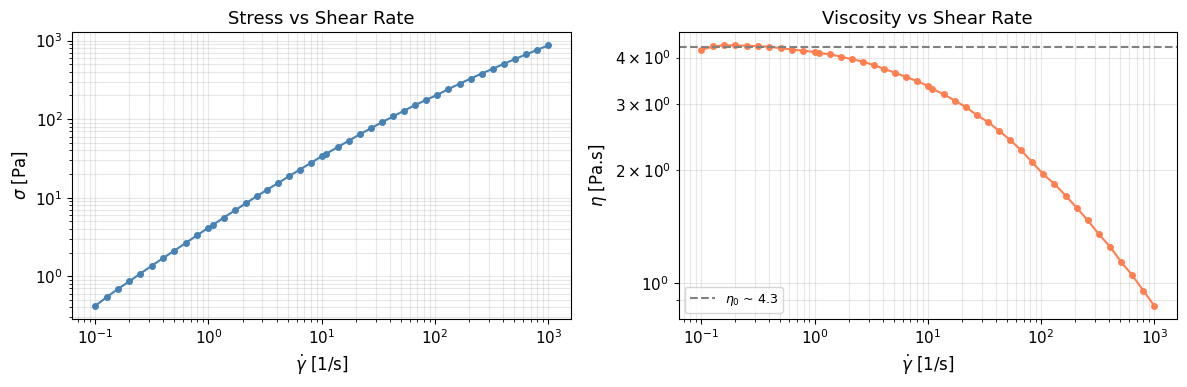

In [6]:
# Check if flow curve shows Newtonian plateau at low rates
gamma_dot = flow_data.x
viscosity = flow_data.y2

# Estimate zero-shear viscosity from lowest 5 points
eta_0_est = np.mean(viscosity[:5])
eta_inf_est = np.min(viscosity)

print(f"Zero-shear viscosity estimate: {eta_0_est:.2f} Pa.s")
print(f"High-shear viscosity: {eta_inf_est:.2f} Pa.s")
print(f"Shear thinning ratio: {eta_0_est / eta_inf_est:.2f}")
print(f"Shear rate range: [{gamma_dot.min():.3g}, {gamma_dot.max():.3g}] 1/s")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.loglog(gamma_dot, flow_data.y, 'o-', ms=4, color='steelblue')
ax1.set_xlabel(r'$\dot{\gamma}$ [1/s]')
ax1.set_ylabel(r'$\sigma$ [Pa]')
ax1.set_title('Stress vs Shear Rate')
ax1.grid(True, alpha=0.3, which='both')

ax2.loglog(gamma_dot, viscosity, 'o-', ms=4, color='coral')
ax2.axhline(eta_0_est, color='gray', ls='--', label=f'$\\eta_0$ ~ {eta_0_est:.1f}')
ax2.set_xlabel(r'$\dot{\gamma}$ [1/s]')
ax2.set_ylabel(r'$\eta$ [Pa.s]')
ax2.set_title('Viscosity vs Shear Rate')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

### 5.2 Creep: Baseline Drift and Early-Time

Late-time slope (dJ/dt): 1.45e-05 1/(Pa.s)
  -> Viscous flow component detected (expected for melt)

Early-time exclusion (t < 0.5 s): 1 points
Retained: 199 / 200 points


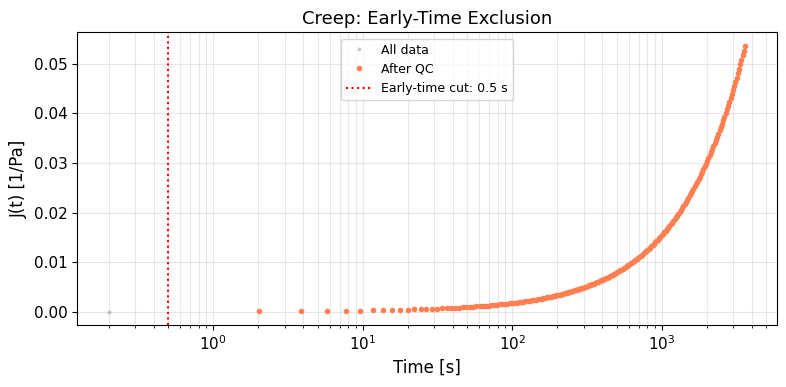

In [7]:
t_creep = creep_data.x
J_creep = creep_data.y

# Check for late-time drift (linear increase = viscous flow)
late_mask = t_creep > 0.7 * t_creep.max()
if np.sum(late_mask) > 5:
    slope = np.polyfit(t_creep[late_mask], J_creep[late_mask], 1)[0]
    print(f"Late-time slope (dJ/dt): {slope:.4g} 1/(Pa.s)")
    if slope > 0:
        print("  -> Viscous flow component detected (expected for melt)")

# Early-time check: exclude inertial ringing (< 0.1 s)
early_cut = 0.5  # seconds
n_excluded = np.sum(t_creep < early_cut)
print(f"\nEarly-time exclusion (t < {early_cut} s): {n_excluded} points")

# Update mask for creep
creep_data.mask = t_creep >= early_cut
print(f"Retained: {creep_data.n_points} / {len(t_creep)} points")

fig, ax = plt.subplots(figsize=(8, 4))
ax.semilogx(t_creep, J_creep, 'o', ms=2, alpha=0.3, color='gray', label='All data')
ax.semilogx(creep_data.x_masked, creep_data.y_masked, 'o', ms=3, color='coral', label='After QC')
ax.axvline(early_cut, color='red', ls=':', label=f'Early-time cut: {early_cut} s')
ax.set_xlabel('Time [s]')
ax.set_ylabel('J(t) [1/Pa]')
ax.set_title('Creep: Early-Time Exclusion')
ax.legend()
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

### 5.3 Relaxation: Log-Time Sampling

Log-time spacing: mean=0.0178, std=0.0400
G(t) range: [4.5, 175.2] Pa
G(t) decay ratio: 38.5x
Late-time CV: 0.1651 (still decaying)


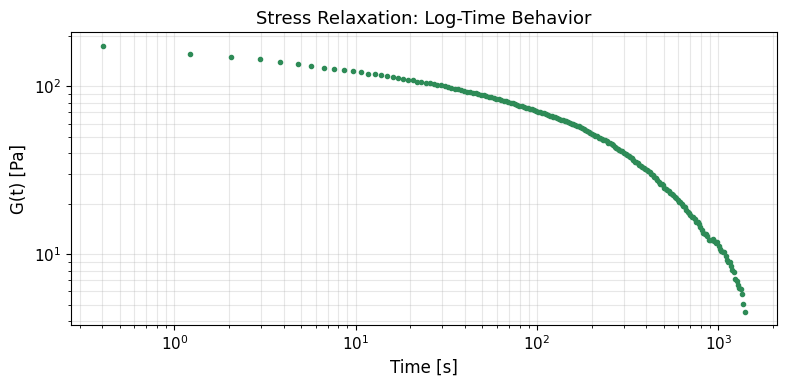

In [8]:
t_relax = relax_data.x
G_relax = relax_data.y

# Check for logarithmic spacing (standard for relaxation)
log_spacing = np.diff(np.log10(t_relax))
print(f"Log-time spacing: mean={np.mean(log_spacing):.4f}, std={np.std(log_spacing):.4f}")
print(f"G(t) range: [{G_relax.min():.1f}, {G_relax.max():.1f}] Pa")
print(f"G(t) decay ratio: {G_relax[0] / G_relax[-1]:.1f}x")

# Check for equilibrium plateau
late_G = G_relax[-10:]
late_cv = np.std(late_G) / np.mean(late_G)
print(f"Late-time CV: {late_cv:.4f} ({'plateau detected' if late_cv < 0.05 else 'still decaying'})")

fig, ax = plt.subplots(figsize=(8, 4))
ax.loglog(t_relax, G_relax, 'o', ms=3, color='seagreen')
ax.set_xlabel('Time [s]')
ax.set_ylabel('G(t) [Pa]')
ax.set_title('Stress Relaxation: Log-Time Behavior')
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

### 5.4 Startup: Stress Overshoot

Applied shear rate: 1.0 1/s
Peak stress: 26.44 Pa at t = 2.010 s (strain = 2.01)
Steady-state stress: 25.20 Pa
Overshoot ratio: 1.05


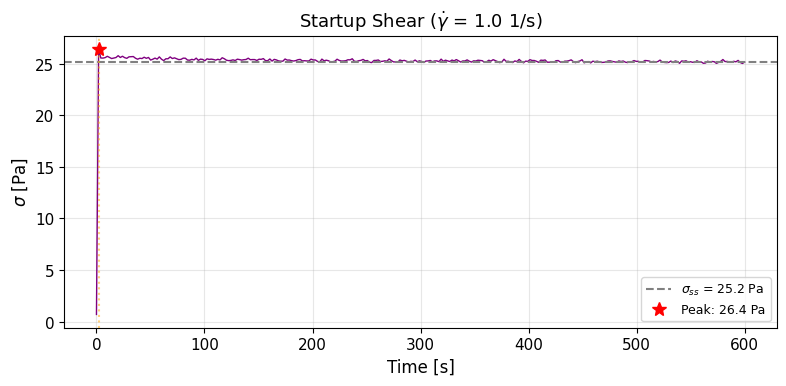

In [9]:
t_start = startup_data.x
sigma_start = startup_data.y
gamma_dot_val = startup_data.protocol_kwargs['gamma_dot']

# Detect stress overshoot
idx_max = np.argmax(sigma_start)
sigma_max = sigma_start[idx_max]
t_max = t_start[idx_max]
gamma_max = gamma_dot_val * t_max

# Estimate steady-state from last 20% of data
late_start = int(0.8 * len(sigma_start))
sigma_ss = np.mean(sigma_start[late_start:])
overshoot_ratio = sigma_max / sigma_ss if sigma_ss > 0 else float('inf')

print(f"Applied shear rate: {gamma_dot_val} 1/s")
print(f"Peak stress: {sigma_max:.2f} Pa at t = {t_max:.3f} s (strain = {gamma_max:.2f})")
print(f"Steady-state stress: {sigma_ss:.2f} Pa")
print(f"Overshoot ratio: {overshoot_ratio:.2f}")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t_start, sigma_start, '-', lw=1, color='purple')
ax.axhline(sigma_ss, color='gray', ls='--', label=f'$\\sigma_{{ss}}$ = {sigma_ss:.1f} Pa')
ax.axvline(t_max, color='orange', ls=':', alpha=0.5)
ax.plot(t_max, sigma_max, 'r*', ms=10, label=f'Peak: {sigma_max:.1f} Pa')
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'$\sigma$ [Pa]')
ax.set_title(f'Startup Shear ($\\dot{{\\gamma}}$ = {gamma_dot_val} 1/s)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.5 SAOS: Crossover and Linear Regime

Crossover frequency: 46.96 rad/s
Crossover modulus: 1848.3 Pa
Estimated relaxation time: 0.021 s

Low-freq slopes (Maxwell: G'~2, G''~1):
  G' slope: 0.99
  G'' slope: 0.85


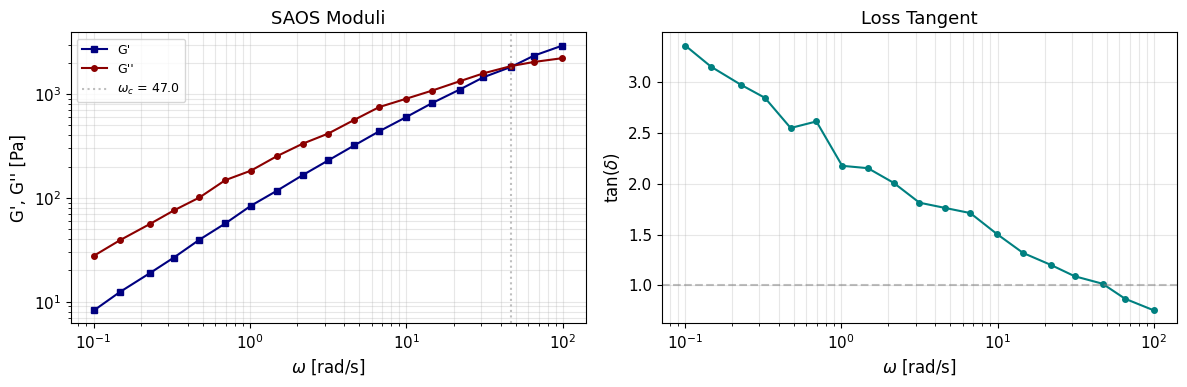

In [10]:
omega = saos_data.x
G_p = saos_data.y2[:, 0]
G_dp = saos_data.y2[:, 1]

# Find crossover frequency
diff = G_p - G_dp
crossover_idx = np.where(np.diff(np.sign(diff)))[0]
if len(crossover_idx) > 0:
    omega_c = omega[crossover_idx[0]]
    G_c = 0.5 * (G_p[crossover_idx[0]] + G_dp[crossover_idx[0]])
    print(f"Crossover frequency: {omega_c:.2f} rad/s")
    print(f"Crossover modulus: {G_c:.1f} Pa")
    print(f"Estimated relaxation time: {1/omega_c:.3f} s")
else:
    print("No crossover detected in frequency range")
    omega_c = None

# Low-frequency behavior: G' ~ omega^2, G'' ~ omega^1 for Maxwell
low_mask = omega < 1.0
if np.sum(low_mask) >= 3:
    slope_Gp = np.polyfit(np.log10(omega[low_mask]), np.log10(G_p[low_mask]), 1)[0]
    slope_Gdp = np.polyfit(np.log10(omega[low_mask]), np.log10(G_dp[low_mask]), 1)[0]
    print(f"\nLow-freq slopes (Maxwell: G'~2, G''~1):")
    print(f"  G' slope: {slope_Gp:.2f}")
    print(f"  G'' slope: {slope_Gdp:.2f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.loglog(omega, G_p, 's-', ms=4, color='navy', label="G'")
ax1.loglog(omega, G_dp, 'o-', ms=4, color='darkred', label="G''")
if omega_c is not None:
    ax1.axvline(omega_c, color='gray', ls=':', alpha=0.5, label=f'$\\omega_c$ = {omega_c:.1f}')
ax1.set_xlabel(r'$\omega$ [rad/s]')
ax1.set_ylabel("G', G'' [Pa]")
ax1.set_title('SAOS Moduli')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

tan_delta = G_dp / G_p
ax2.semilogx(omega, tan_delta, 'o-', ms=4, color='teal')
ax2.axhline(1, color='gray', ls='--', alpha=0.5)
ax2.set_xlabel(r'$\omega$ [rad/s]')
ax2.set_ylabel(r'tan($\delta$)')
ax2.set_title('Loss Tangent')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

### 5.6 LAOS: Cycle Identification and Transient Removal

omega = 1.0 rad/s, T = 6.28 s
gamma_0 = 0.5120
Total time: 66.0 s -> 10.5 cycles
Points per cycle: ~48

Dropping first 2 cycles (t < 12.6 s)
Retained: 404 / 500 points


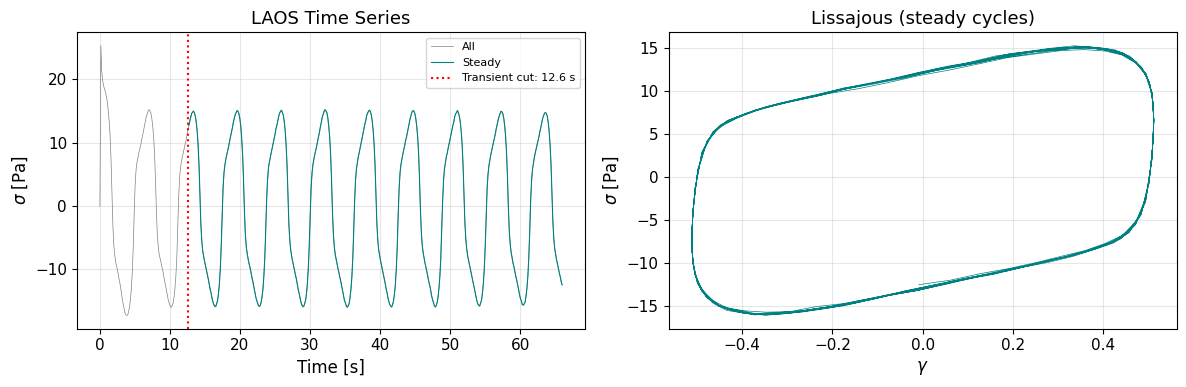

In [11]:
t_laos = laos_data.x
strain_laos = laos_data.y2
stress_laos = laos_data.y
omega_laos = laos_data.metadata['omega']
gamma_0_est = laos_data.metadata['gamma_0']

# Estimate period and number of cycles
period = 2 * np.pi / omega_laos
total_time = t_laos[-1] - t_laos[0]
n_cycles = total_time / period

print(f"omega = {omega_laos} rad/s, T = {period:.2f} s")
print(f"gamma_0 = {gamma_0_est:.4f}")
print(f"Total time: {total_time:.1f} s -> {n_cycles:.1f} cycles")
print(f"Points per cycle: ~{len(t_laos) / n_cycles:.0f}")

# Recommend dropping first 2 cycles as transient
n_drop = 2
t_cut = t_laos[0] + n_drop * period
steady_mask = t_laos >= t_cut
laos_data.mask = steady_mask
print(f"\nDropping first {n_drop} cycles (t < {t_cut:.1f} s)")
print(f"Retained: {laos_data.n_points} / {len(t_laos)} points")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(t_laos, stress_laos, '-', lw=0.5, color='gray', label='All')
ax1.plot(t_laos[steady_mask], stress_laos[steady_mask], '-', lw=0.8, color='teal', label='Steady')
ax1.axvline(t_cut, color='red', ls=':', label=f'Transient cut: {t_cut:.1f} s')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel(r'$\sigma$ [Pa]')
ax1.set_title('LAOS Time Series')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# Lissajous (steady-state only)
ax2.plot(strain_laos[steady_mask], stress_laos[steady_mask], '-', lw=0.5, color='teal')
ax2.set_xlabel(r'$\gamma$')
ax2.set_ylabel(r'$\sigma$ [Pa]')
ax2.set_title('Lissajous (steady cycles)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary and Next Steps

All datasets are now loaded, validated, and stored in `ProtocolData` objects with QC-applied masks. Downstream notebooks (09-15) import these same loaders to get consistent, pre-processed data for NLSQ→NUTS inference.

## Further Reading

**Handbook Documentation:**
- [HVNM Knowledge Extraction](../../docs/source/models/hvnm/hvnm_knowledge.rst) — Multi-protocol fitting strategies, cross-protocol validation workflows
- [HVNM Model Reference](../../docs/source/models/hvnm/hvnm.rst) — Protocol-specific requirements and parameter identifiability

**Key References:**
1. Karim, M.R., Vernerey, F. & Sain, T. (2025). *Macromolecules*, 58(10), 4899-4912.

## Next Notebooks

- **Notebook 09**: Flow curve NLSQ/NUTS — 2-parameter inference ($G_D$, $k_{d,D}$)
- **Notebook 13**: SAOS NLSQ/NUTS — 5-parameter inference (full network moduli)
- **Notebook 15**: Global multi-protocol — Joint inference across protocols